# Purpose and scope

`kernel_baseline.py` implements a complete baseline pipeline for selecting representative directed acyclic graphs (DAGs) via Weisfeiler–Lehman (WL) feature hashing and k-medoids clustering. It loads pickled NetworkX DAGs, builds fixed-dimensional sparse feature vectors per graph, normalizes them, clusters graphs using cosine distance, optionally applies a CLARA-style approximation for large datasets, and writes out the selected medoid graphs plus diagnostic plots and embeddings.

### Input data model

Graphs are loaded from pickle files under a configurable directory and glob pattern. The loader accepts `nx.DiGraph` directly or collapses parallel edges from `nx.MultiDiGraph`. It asserts acyclicity and guards against empty graphs by inserting a single node. The selection uses only adjacency and optional node attributes (if specified) for initial labels.

## Feature construction (Directed WL with hashing)

The core representation is a directed Weisfeiler–Lehman subtree feature map:

- **Initial labels (t=0)**: For each node, the label is either a user-specified node attribute (`--node_label_attr`) or a structural signature `in{deg}_out{deg}`.
- **Directed refinement (t=1..h)**: At each iteration, each node's new label is the MD5 hash of the concatenated multiset of incoming and outgoing neighbor labels:
  ```
  label(v) | IN: sorted(predecessor labels) | OUT: sorted(successor labels)
  ```
- **Feature hashing**: For every iteration's labels, counts are accumulated into a fixed-size vector of dimension `hash_dim` using an MD5-based bucket index. This produces a sparse N × hash_dim matrix with hashed label-count features for each graph.
- **Normalization**: Row-wise L2 normalization yields unit-norm feature vectors suitable for cosine similarity.

This design provides a scalable, order-invariant, directed WL embedding while avoiding large dictionaries by hashing into a fixed dimensionality.

## Similarity and distance

Because all vectors are L2-normalized, cosine similarity between two graphs is simply the dot product, and cosine distance is derived as:

$$
d(x, y) = \sqrt(2 − 2 \cos(x, y))
$$

For moderate N, it computes the full N × N similarity matrix; for large N, it computes similarities only to medoids to avoid quadratic memory.

## Clustering and selection (k-medoids)

The script selects representative graphs via k-medoids clustering:

- **Initialization**: k-medoids++ analog that samples initial medoids proportional to squared distance.
- **Lloyd-style updates**: Reassign each graph to nearest medoid, then recompute medoids within clusters by minimizing sum of intra-cluster distances (not full PAM swaps).
- **Multi-start**: Optional multiple restarts (`--n_init`) retain the lowest inertia solution.

### Large-N approximation (CLARA + polishing)

If N > `max_full_n`, it uses a CLARA-style scheme:

1. Sample a subset (size raised to at least `max(10k, 0.02N, 1000)`).
2. Run full k-medoids on the subset and lift medoids to global indices.
3. Evaluate full-data assignment via distances to medoids only.
4. Keep the best trial across `--clara_trials`.
5. **Polish medoids** on full data: for each cluster, sample candidate points (plus current medoid) and select the one minimizing distance to all cluster points. Repeat for `--polish_rounds`.

This yields higher-quality medoids without computing full N × N distances.

### Outputs

For each k:

- `final_selected_graphs_k{k}.json` containing:
  - selected medoid indices and filenames
  - cluster sizes/weights and labels
  - WL parameters, hashing dimension, seed, and clustering mode
  - inertia and dataset metadata
- **Embedding and diagnostics** in `--out_dir`:
  - numpy arrays: `embed_k{k}_features.npy`, `embed_k{k}_similarities.npy`, `embed_k{k}_distances.npy`
  - plots: PCA, UMAP, and t-SNE of the distance-to-medoids embedding (t-SNE uses a subsample)

## Algorithmic characteristics

- **Streaming WL features**: One graph at a time, avoids storing all graphs in memory.
- **Sparse representation**: Feature matrix is CSR, hashed counts.
- **Scalability**: Full N × N only for N ≤ max_full_n; otherwise CLARA approximation with full-data refinement.
- **Reproducibility**: All stochastic components are seeded.

### Key parameters

- `--wl_iterations` (h): depth of WL refinement
- `--hash_dim`: size of hashed feature space
- `--k_values`: list of cluster counts to evaluate
- `--max_full_n`: threshold for full vs CLARA mode
- `--subset_size`, `--clara_trials`, `--polish_rounds`: CLARA controls


In [ ]:
import json
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE 
from umap import UMAP
import sys
import kernel_baseline as kb  
from tqdm import tqdm

REPO = Path.cwd()  
GRAPH_DIR = REPO / "data" / "sub20" / "graphs"
OUT_DIR = REPO / "outputs_final"
KERNELS_PATH = REPO / "src" / "kernels"
ROOT = REPO / "src" / "kernels"
N = 49125

json20 = OUT_DIR / "final_selected_graphs_k20.json" 
json100 = OUT_DIR / "final_selected_graphs_k100.json"

s20 = json.loads(json20.read_text())
s100 = json.loads(json100.read_text())

/Users/ignaciagothe/Desktop/Proyecto firespread L.Murray/graph_scenarios/.venv/lib/python3.14/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
ROOT = REPO / "src" / "kernels"


================================================================ k = 20 =============================================================






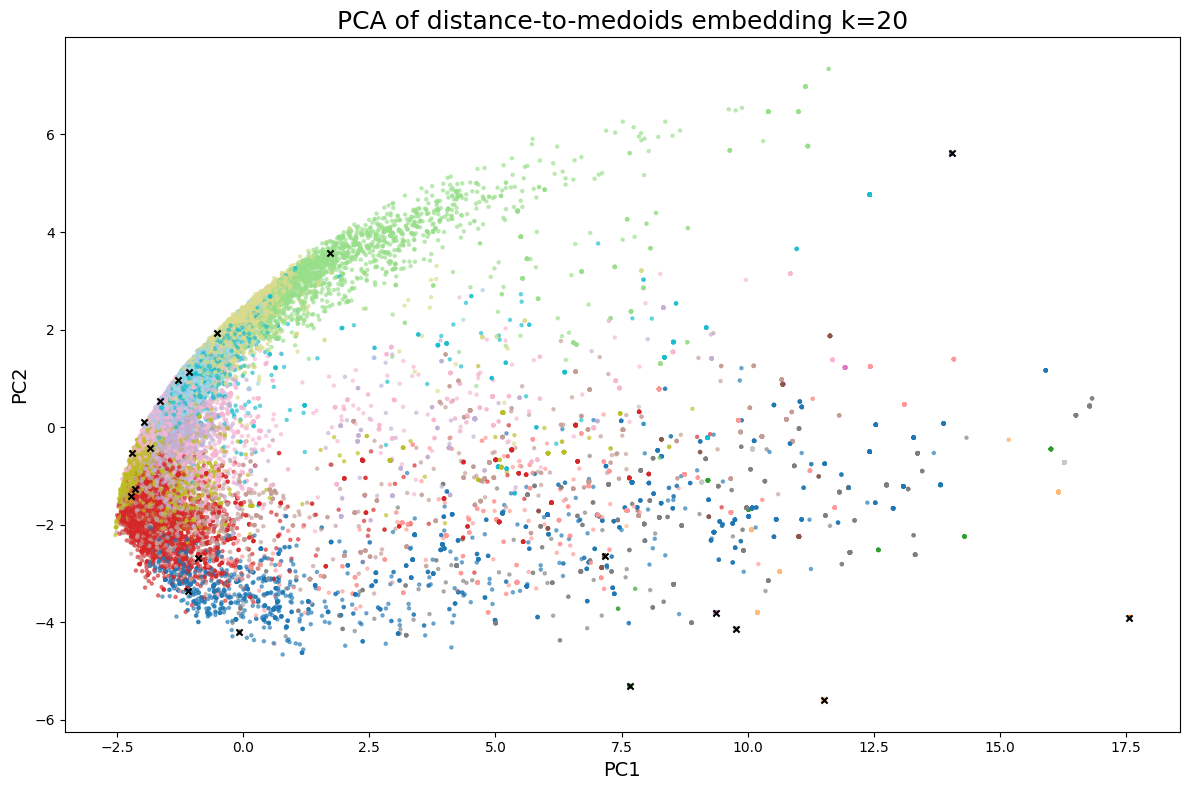

/Users/ignaciagothe/Desktop/Proyecto firespread L.Murray/graph_scenarios/.venv/lib/python3.14/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


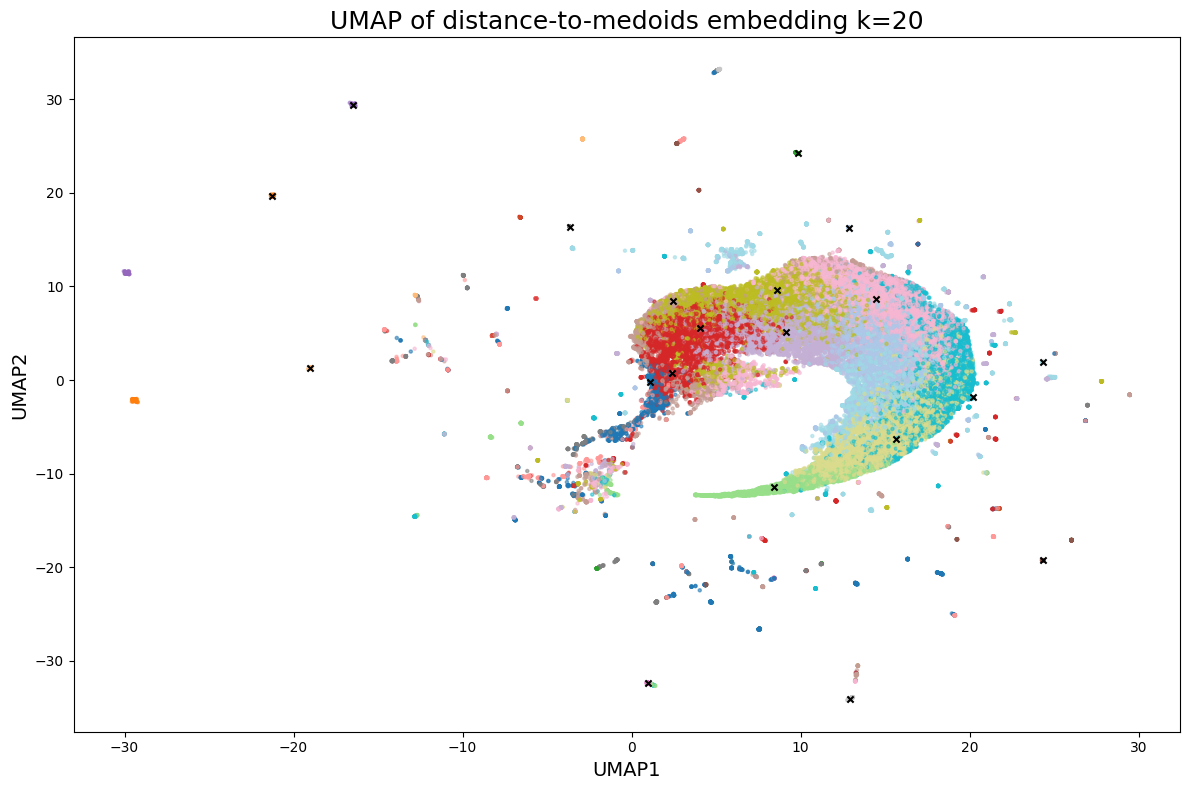

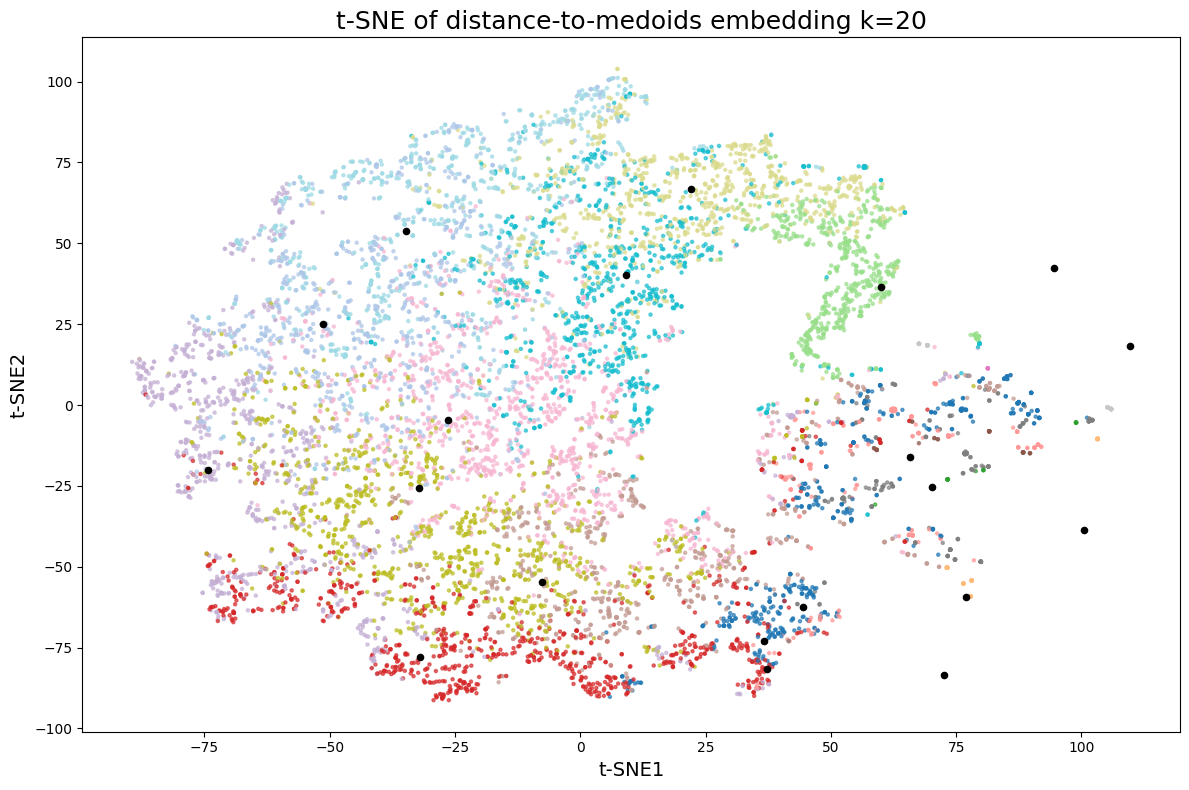



 ============================================================== k = 100 =========================================================== 






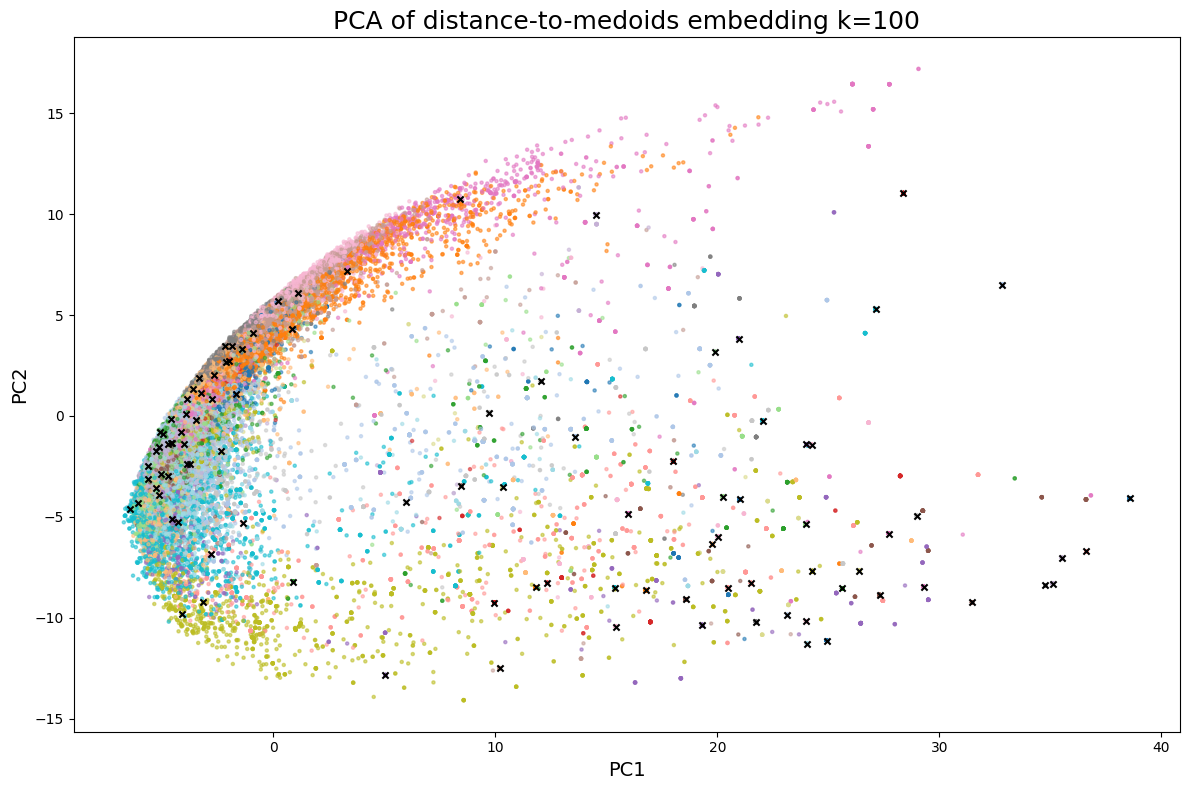

/Users/ignaciagothe/Desktop/Proyecto firespread L.Murray/graph_scenarios/.venv/lib/python3.14/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


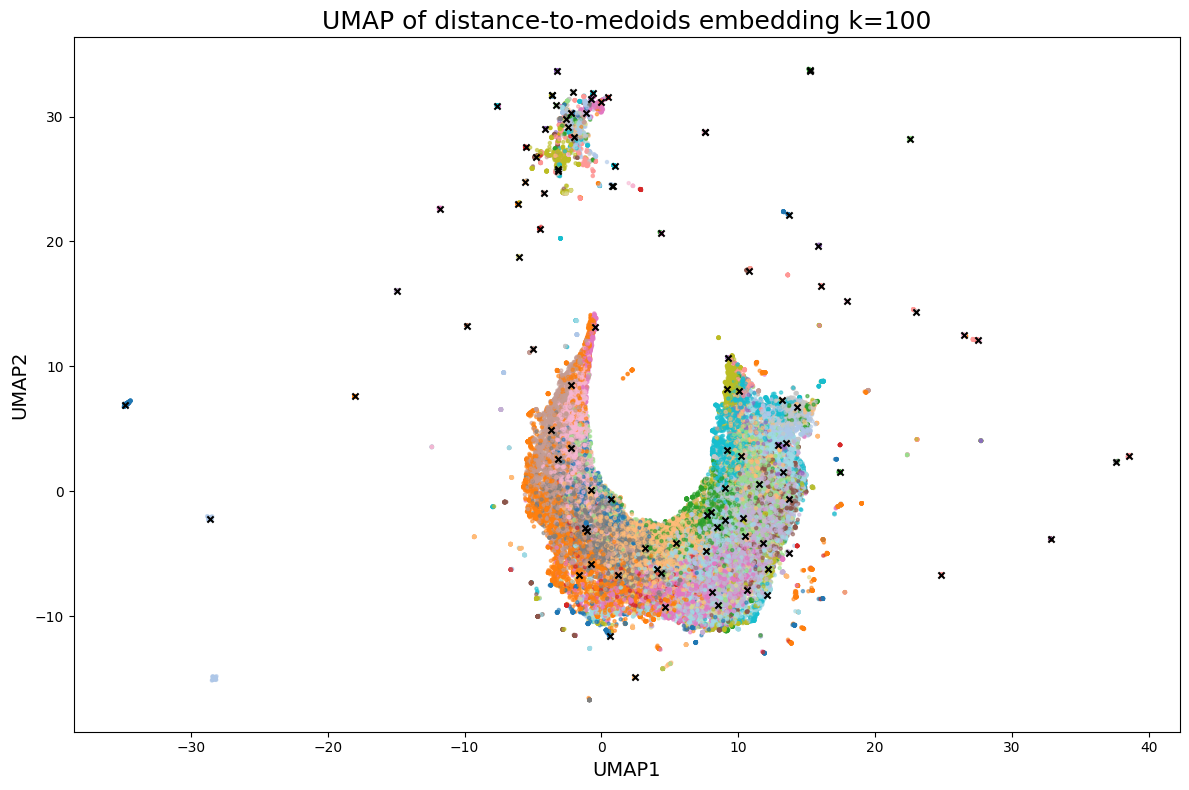

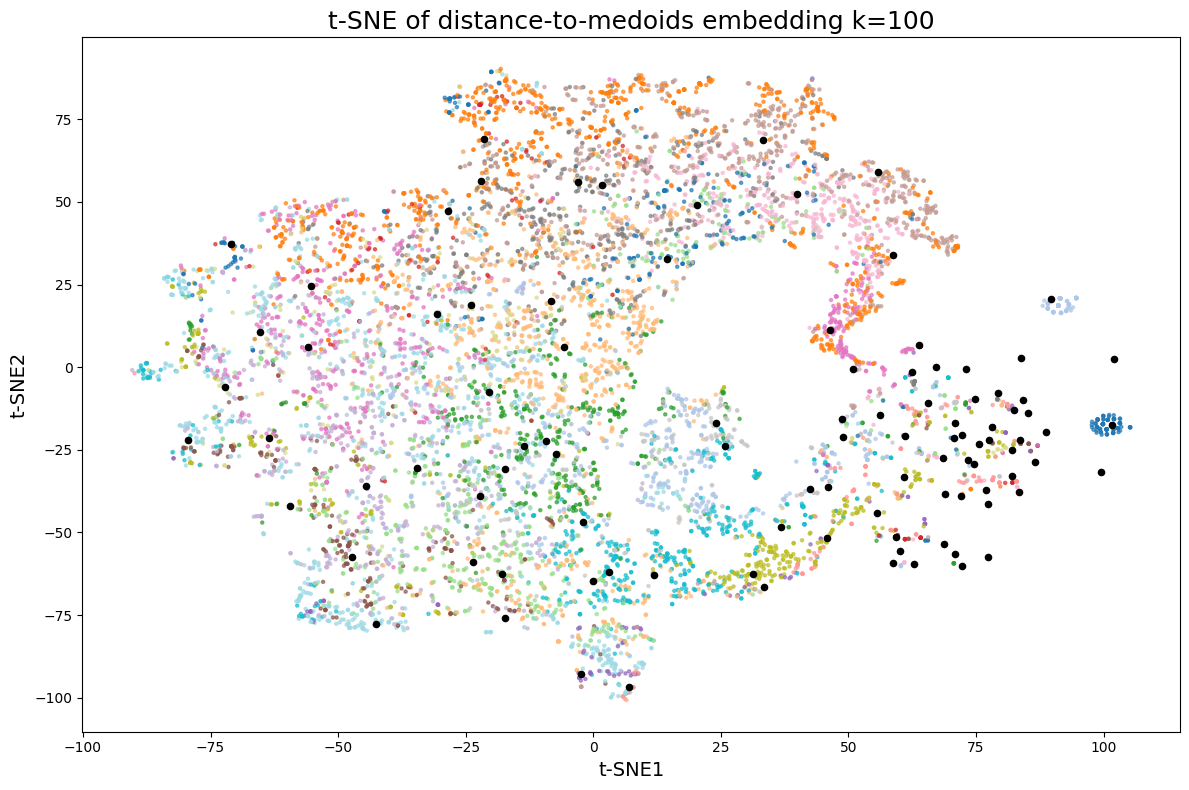

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from umap import UMAP

rng = np.random.default_rng(16)

for k, sel in [(20, s20), (100, s100)]:
    medoids = np.asarray(sel["selected_indices"], dtype=int)
    labels  = np.asarray(sel["cluster_labels"], dtype=int)

    E = np.load(OUT_DIR / f"embed_k{k}_distances.npy")   # shape (N,k)
    assert E.shape[0] == labels.shape[0], "labels must align with E rows"
    assert E.shape[1] == k, "E must be N×k for this k"

    # --- standardize columns (important) ---
    E0 = (E - E.mean(axis=0)) / (E.std(axis=0) + 1e-12)

    # --- clip extremes to reduce outlier leverage in plots (viz only) ---
    lo = np.quantile(E0, 0.01, axis=0)
    hi = np.quantile(E0, 0.99, axis=0)
    E0 = np.clip(E0, lo, hi)

    N = E0.shape[0]

    # better colormap for many clusters
    cmap = "tab20" if k <= 20 else plt.cm.get_cmap("gist_ncar", k)

    # ================= PCA =================
    Zp = PCA(n_components=2, random_state=42).fit_transform(E0)

    plt.figure(figsize=(12, 8))
    plt.scatter(Zp[:, 0], Zp[:, 1], s=5, c=labels, cmap=cmap, alpha=0.55)
    plt.scatter(Zp[medoids, 0], Zp[medoids, 1], s=45, c="black", marker="x", linewidths=2)
    plt.title(f"PCA projection of distance-to-medoids embedding (k={k})", fontsize=16)
    plt.xlabel("PC1"); plt.ylabel("PC2")
    plt.tight_layout()
    plt.show()

    # ================= UMAP =================

    nn = 120 if k == 20 else 200
    md = 0.15 if k == 20 else 0.20

    Zu = UMAP(
        n_components=2,
        n_neighbors=nn,
        min_dist=md,
        metric="euclidean",
        init="spectral",
        random_state=42,
        n_jobs=-1,
    ).fit_transform(E0)

    plt.figure(figsize=(12, 8))
    plt.scatter(Zu[:, 0], Zu[:, 1], s=5, c=labels, cmap=cmap, alpha=0.55)
    plt.scatter(Zu[medoids, 0], Zu[medoids, 1], s=45, c="black", marker="x", linewidths=2)
    plt.title(f"UMAP projection of distance-to-medoids embedding (k={k})", fontsize=16)
    plt.xlabel("UMAP1"); plt.ylabel("UMAP2")
    plt.tight_layout()
    plt.show()

    # ================= t-SNE (stratified ~10k) =================
    target = 10000
    uniq = np.unique(labels)

    # proportional sample per cluster, with caps
    counts = np.array([(labels == c).sum() for c in uniq])
    per_cluster = np.clip(((counts / counts.sum()) * target).round().astype(int), 5, 500)

    idx_list = []
    for c, m in zip(uniq, per_cluster):
        pool = np.where(labels == c)[0]
        m = min(m, pool.size)
        idx_list.extend(rng.choice(pool, size=m, replace=False).tolist())

    # always include medoids
    idx_list.extend(medoids.tolist())
    idx = np.array(sorted(set(idx_list)), dtype=int)

    # fill to target if needed
    if idx.size < target:
        remaining = np.setdiff1d(np.arange(N), idx)
        fill = rng.choice(remaining, size=(target - idx.size), replace=False)
        idx = np.concatenate([idx, fill])

    Et = E0[idx]


    n_svd = min(50, Et.shape[1])
    Et_red = PCA(n_components=n_svd, random_state=42).fit_transform(Et)

    Zt = TSNE(
        n_components=2,
        init="pca",
        learning_rate="auto",
        perplexity=50,
        early_exaggeration=12,
        random_state=42,
    ).fit_transform(Et_red)

    plt.figure(figsize=(12, 8))
    plt.scatter(Zt[:, 0], Zt[:, 1], s=5, c=labels[idx], cmap=cmap, alpha=0.65)


    pos = {int(i): j for j, i in enumerate(idx.tolist())}
    mid_in = [pos[int(m)] for m in medoids.tolist() if int(m) in pos]
    if mid_in:
        plt.scatter(Zt[mid_in, 0], Zt[mid_in, 1], s=60, c="black", marker="x", linewidths=2)

    plt.title(f"t-SNE projection of distance-to-medoids embedding (k={k}; n={idx.size})", fontsize=16)
    plt.xlabel("t-SNE1"); plt.ylabel("t-SNE2")
    plt.tight_layout()
    plt.show()


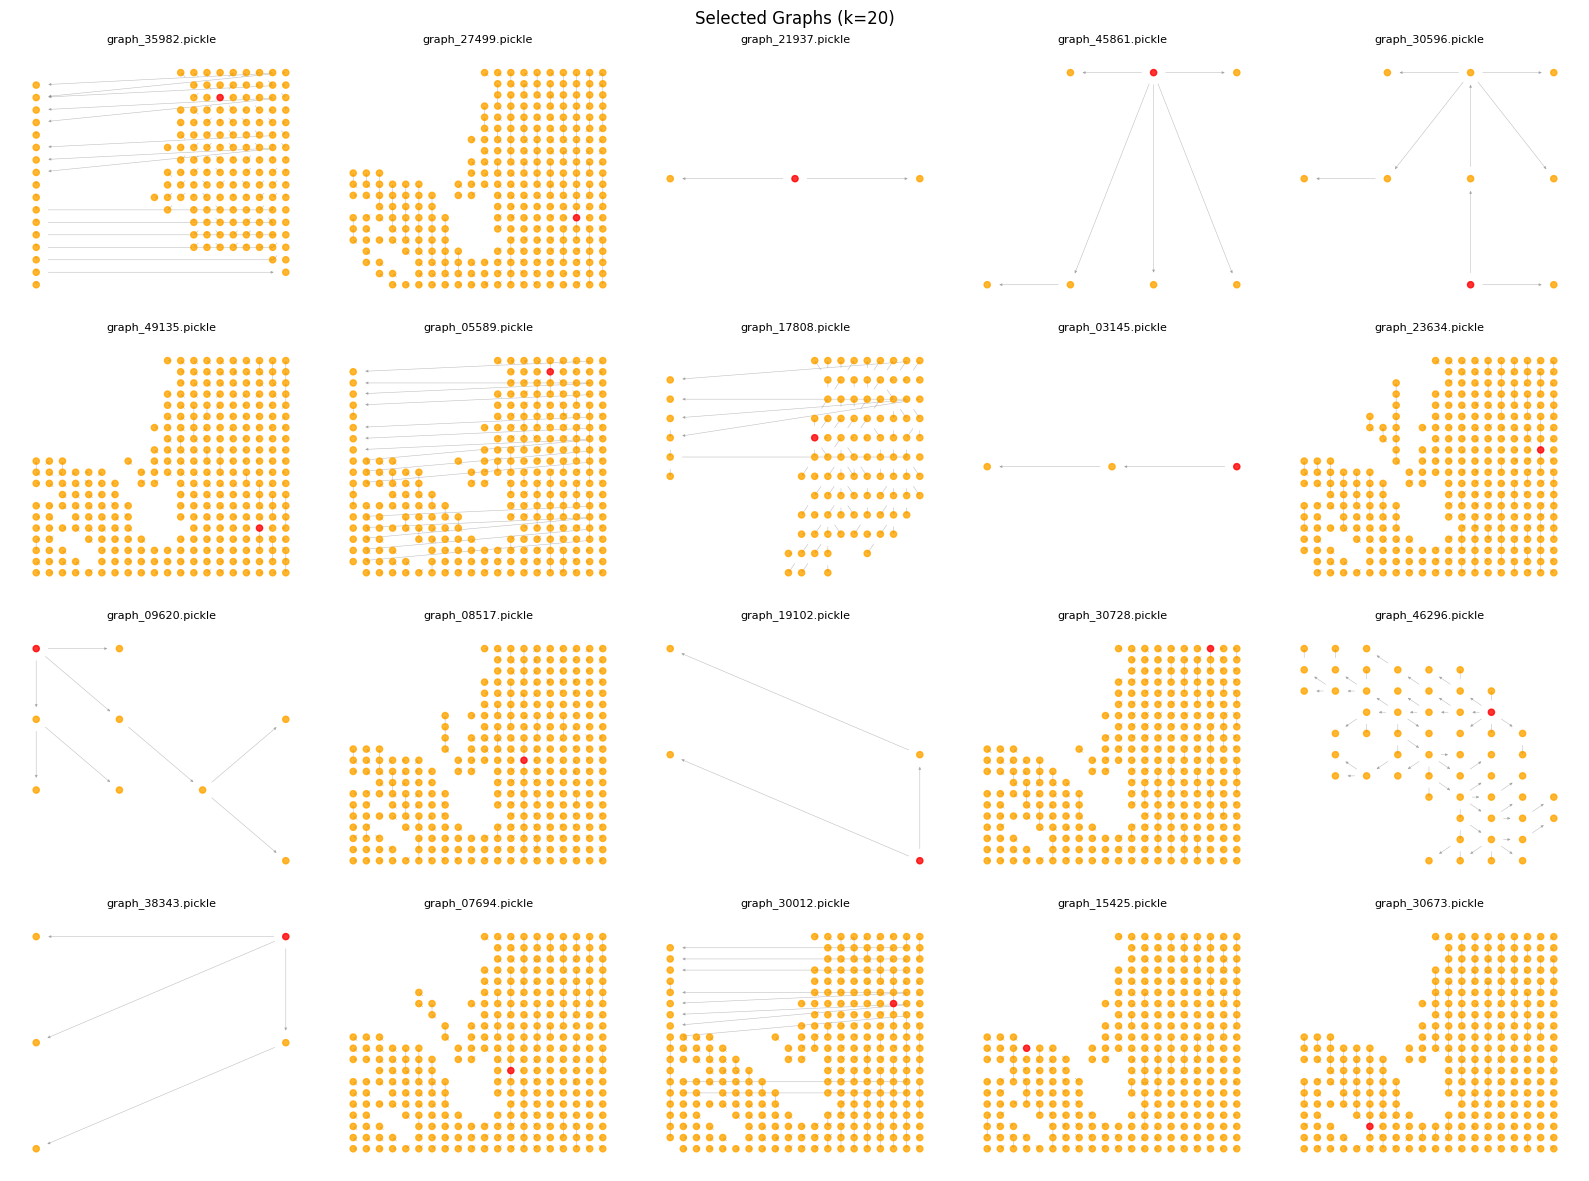




 ------------------------------------------------------------------------------------------------------------------------------------ 



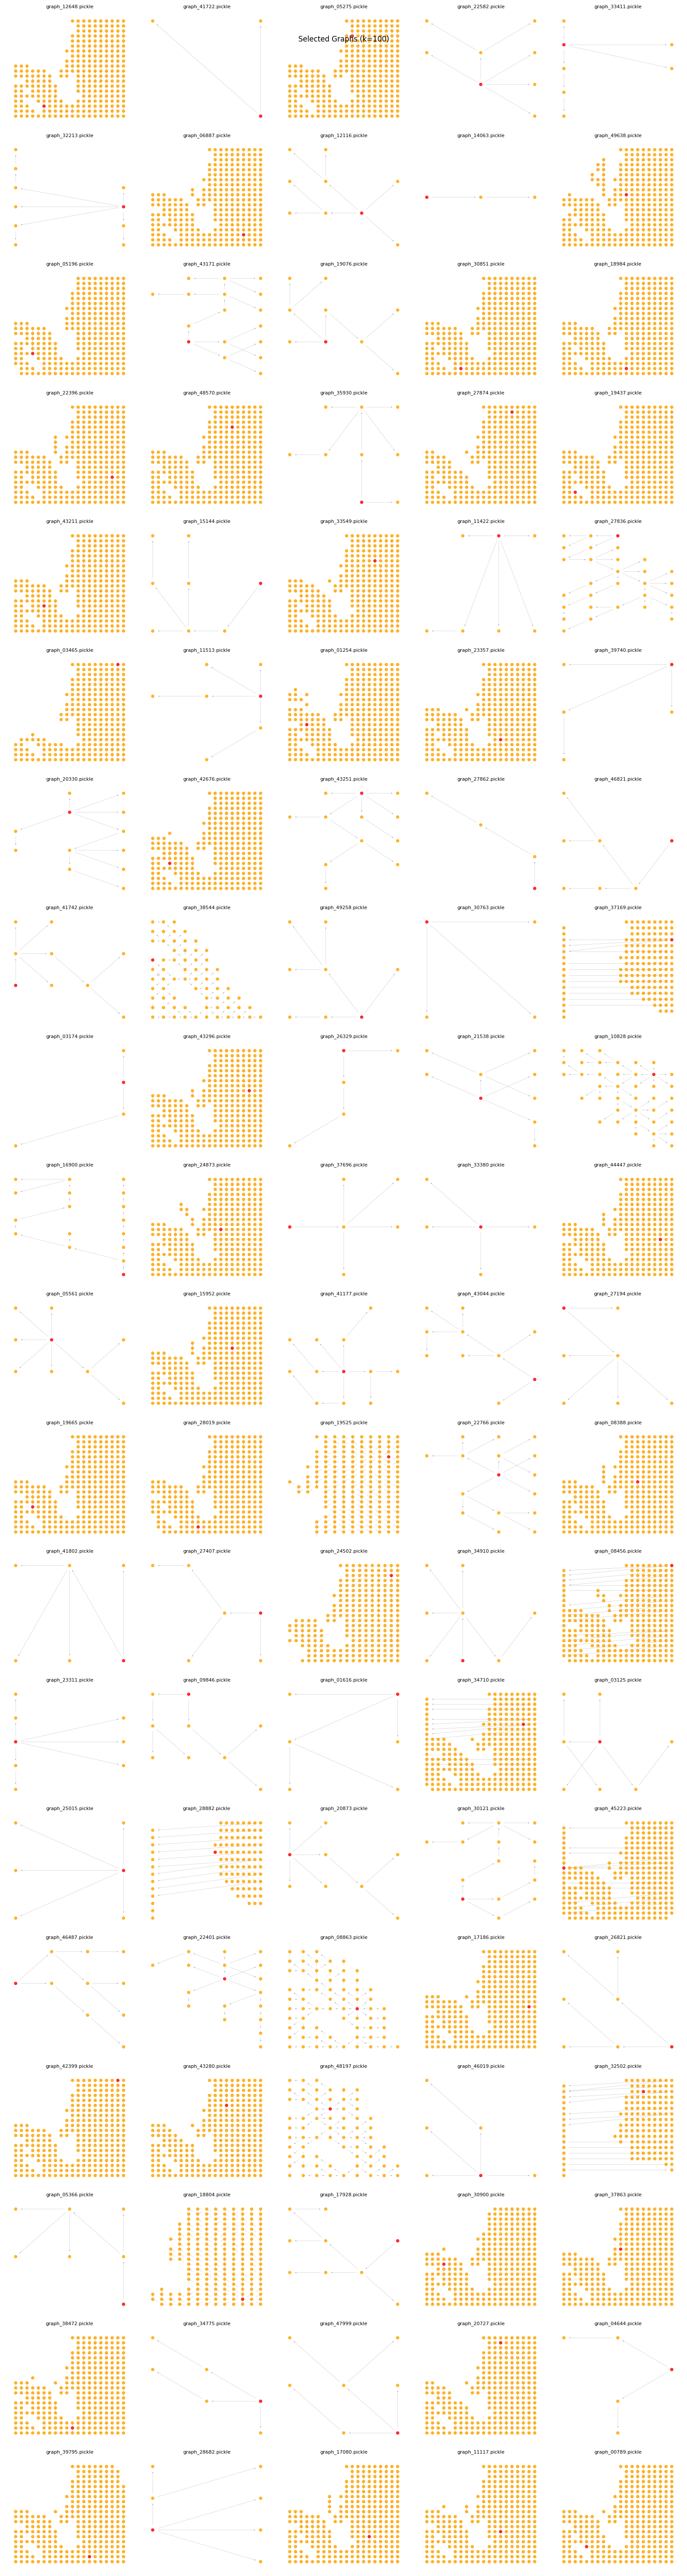

In [21]:


def grid_positions_20(G):
    """Compute grid positions for 20x20 lattice."""
    nodes = list(G.nodes())
    if not nodes:
        return None
    if not all(isinstance(n, (int, np.integer)) for n in nodes):
        return None
    
    min_n, max_n = int(min(nodes)), int(max(nodes))
    if 0 <= min_n and max_n <= 399:
        offset = 0
    elif 1 <= min_n and max_n <= 400:
        offset = 1
    else:
        return None
    
    pos = {}
    for node in nodes:
        idx = int(node) - offset
        row = idx // 20
        col = idx % 20
        pos[node] = (col, 19 - row)
    return pos


def draw_fire_spread_graph(G, ax, title=''):
    """Draw fire spread graph on grid or spring layout."""
    pos = grid_positions_20(G)
    if pos is None:
        pos = nx.spring_layout(G, seed=42)

    ignition_nodes = [n for n in G.nodes() if G.in_degree(n) == 0] if G.is_directed() else []
    node_colors = ['red' if n in ignition_nodes else 'orange' for n in G.nodes()]

    nx.draw_networkx_nodes(G, pos, ax=ax, node_size=20, node_color=node_colors, alpha=0.8)
    nx.draw_networkx_edges(
        G, pos, ax=ax, edge_color='gray', alpha=0.5, 
        arrows=G.is_directed(), arrowsize=4, width=0.4
    )

    ax.set_title(title, fontsize=8)
    ax.set_axis_off()


def plot_selected_graphs(k):
    """Plot all selected graphs for given k."""
    s=selections[k]
    selected_files = s["selected_pickle_files"]

    cols = 5
    rows = int(np.ceil(len(selected_files) / cols))
    fig, axes = plt.subplots(rows, cols, figsize=(cols * 3.2, rows * 3.0))
    axes = np.array(axes).reshape(-1)
    
    for i, fname in enumerate(selected_files):
       
        G = pickle.load(open(Path(f'/Users/ignaciagothe/Desktop/Proyecto firespread L.Murray/graph_scenarios/data/sub20/graphs/{fname}'), "rb"))
        title = f"{fname}"
        draw_fire_spread_graph(G, axes[i], title)
    
    for j in range(i + 1, len(axes)):
        axes[j].axis("off")
    
    plt.suptitle(f"Selected Graphs (k={k})", fontsize=12)
    plt.tight_layout()
    plt.show()


# Plot for the last k value
plot_selected_graphs(20)
print("\n")

print("\n ------------------------------------------------------------------------------------------------------------------------------------ \n")
plot_selected_graphs(100)